Нужно понять, стали ли мы больше зарабатывать с пользователя или нет на основании результатов А/B тестирования. Проверяем с помощью t-теста, U-теста Mann-Whitney и бутстрапа.

In [1]:
# Импортируем основные библиотеки
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns



from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# Читаем файл, сразу ставим разделитель и делаем так, чтобы индексы строк не превращались в отдельную колонку.
data = pd.read_csv('hw_bootstrap.csv', sep = (';'), index_col=[0])

In [3]:
data

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control
...,...,...
996,1000,Treatment
997,1200,Treatment
998,1500,Treatment
999,2000,Treatment


In [4]:
# Видим, что колонка value - объект. Нам нужно числовое значение
data.dtypes

value                object
experimentVariant    object
dtype: object

In [5]:
# Чтобы нам перевести value в число с плавающей точкой, необходимо сначала поменять запятую в колонках на точку.
data['value'] = data.value.apply(lambda x: x.replace(',', '.')) # Воспользуемся лямбда функцией и методом replace

In [6]:
# Конвертируем тип данных в колонке value в float
data = data.astype({'value': 'float'})

In [7]:
# Проверили, получилось.
data.dtypes

value                float64
experimentVariant     object
dtype: object

In [8]:
# Выглядит не очень презентабельно, можно округлить до двух знаков после запятой. 
data

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control
...,...,...
996,1000.000000,Treatment
997,1200.000000,Treatment
998,1500.000000,Treatment
999,2000.000000,Treatment


In [9]:
data['value'] = data['value'].round(2) #Округляем

In [10]:
data

,value,experimentVariant
1,10.38,Control
2,9.55,Control
3,11.09,Control
4,10.15,Control
5,9.79,Control
...,...,...
996,1000.00,Treatment
997,1200.00,Treatment
998,1500.00,Treatment
999,2000.00,Treatment


In [11]:
# Разбиваем датафрейм отдельно на тестовую и контрольную группы
test_data = data.query('experimentVariant == "Treatment"')

In [12]:
test_data

,value,experimentVariant
501,10.38,Treatment
502,9.55,Treatment
503,11.09,Treatment
504,10.15,Treatment
505,9.79,Treatment
...,...,...
996,1000.00,Treatment
997,1200.00,Treatment
998,1500.00,Treatment
999,2000.00,Treatment


In [13]:
control_data = data.query('experimentVariant == "Control"')

In [14]:
control_data

,value,experimentVariant
1,10.38,Control
2,9.55,Control
3,11.09,Control
4,10.15,Control
5,9.79,Control
...,...,...
496,10.97,Control
497,10.26,Control
498,8.78,Control
499,11.17,Control


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


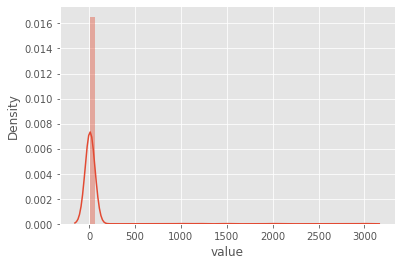

In [15]:
# Строим гистограмму по значениям в тестовой группе.В тестовой группе есть аномально большие выбросы, нам необходимо это учесть.
sns.distplot(test_data.value)

In [16]:
# Попробуем построить гистограмму без выбросов.
test_data_norm = test_data.query('value < 500')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


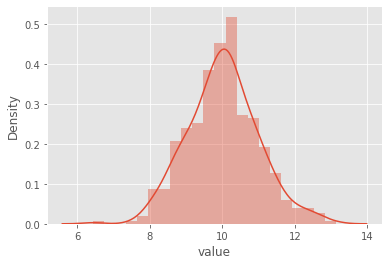

In [17]:
# Строим гистограмму тестовой группы без выбросов, напоминает нормальное распределение. Примем это во внимание.
sns.distplot(test_data_norm.value)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


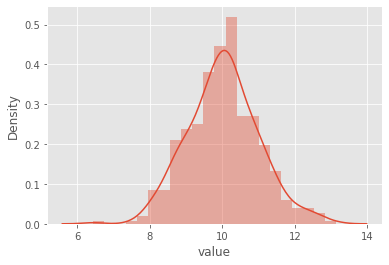

In [18]:
# Строим гистограмму по значениям в контрольной группе и видим, что распределение напоминает нормальное.
sns.distplot(control_data.value)

In [19]:
# Посмотрим на средние значения в тесте и контроле
test_data.value.mean()

27.32148

In [20]:
control_data.value.mean()

10.02684

На первый взгляд средние значения в контроле и тесте отличаются сильно. Начнем выполнять нашу задачу. 
У нас есть результаты А/B теста и наша задача проверить, стали ли мы зарабатывать больше с пользователя или нет.
Н0 - изменений нет (зарабатывать больше не стали). Н1 - изменения есть.
Попробуем посчитать p-value тремя способами: t-тест, U-тест, бутстрап средних. С выбросами ничего делать не будем, просто будем иметь в виду, что они есть.

1. T-test. 
Для T-теста нам необходимо соблюдение следующих условий:
1) Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий).
2) Требование к нормальности данных обеих групп при применении t-теста. 

In [21]:
# Проверим наши выборки на гомогенность дисперсий
stats.levene(test_data.value, control_data.value, center='mean')

LeveneResult(statistic=16.67746285012671, pvalue=4.785166981784113e-05)

In [22]:
# P-value < 0.05, значит дисперсии в наших выборках не гомогенны.

In [23]:
# Теперь проверим наши выборки на нормальное распределение.
from scipy import stats
stats.shapiro(test_data.value)

ShapiroResult(statistic=0.07038962841033936, pvalue=1.0930128021733573e-43)

В тестовой группе распределение ненормальное, но это можно было увидеть и на графике, т.к. присутствуют аномальные выбросы.

In [24]:
from scipy import stats
stats.shapiro(control_data.value)

ShapiroResult(statistic=0.9959195256233215, pvalue=0.22321730852127075)

В контрольной группе распределение нормальное

In [25]:
# Если смотреть строго на кретерии для T-теста, то данный тест не очень подходит к нашим выборкам, но мы его все равно проведем.
stats.ttest_ind(control_data.value, test_data.value)

Ttest_indResult(statistic=-2.0729029158594887, pvalue=0.03843751270070384)

Итак, согласно т-тесту pvalue < 0.05, т.е. у нас есть основания отклонить нулевую гепотезу. Однако мы знаем, что t-test плохо реагирует на выбросы. Для более тщательной проверки у нас есть еще 2 теста

2. U-test Манна-Уитни. 
Данный тест менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов и, соответственно, подходит нам больше.

In [26]:
stats.mannwhitneyu(control_data.value, test_data.value, alternative='two-sided') # Проводим тест

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592128779770452)

В итоге P-value > 0.05, т.е. согласно этому тесту отклонить нулевую гепотезу мы не можем. Теперь проведем bootstrap тест

In [27]:
# Подготовим данные для бутстрапа
data_column_1 = control_data.value

In [28]:
data_column_2 = test_data.value

In [29]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [30]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [31]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [32]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

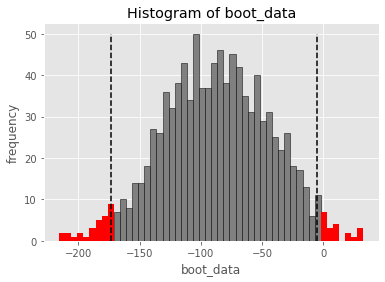

In [33]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [34]:
booted_data["p_value"] # альфа

0.04564731158962379

In [35]:
booted_data["quants"] # Доверительный интервал

,0
0.025,-173.270058
0.975,-4.865217


По результатам бутстрапа мы видим, что 0 не попадает в доверительный интервал. Следовательно, в соответствии с этим тестом, у нас есть основания отклонить нулевую гепотезу о том, что зарабатывать мы больше не стали.

А теперь попробуем с помощью бутсртрапа сравнить не средние значения, а медианные.

In [36]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [39]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [40]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

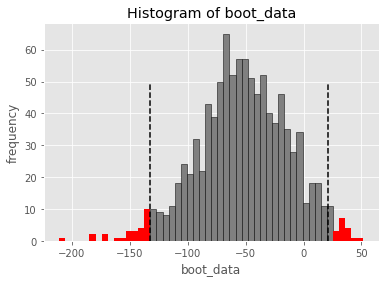

In [41]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [42]:
booted_data["p_value"] # альфа

0.17945936791793604

In [43]:
booted_data["quants"] # Доверительный интервал

,0
0.025,-132.773455
0.975,21.388941


0 попадает в доверительный интервал, а также p-value > 0.05, следовательно, отклонить нулевую гепотезу мы не можем

ИТОГО: при проверки гепотезы с помощью t-кретерия и бутстрапа средних результаты дали нам основания отклонить нулевую гепотезу о равенстве средных значений, проверка гепотезы с помощью u-кретерия не дает нам  оснований полагать, что выборки не равны, также и бутстрап медианных значений не дает нам право отклонить нулевую гепотезу.
При этом мы имеем в виду, что:
1. В тестовой группе есть аномальные значения, в сотни раз превышающие бОльшую часть значений выборки.
2. Распределение в тестовой группе из-за аномальных значений не является нормальным.
3. Дисперсии в тестовой и контрольной группах не равны все по той же причине.

Исходя из того, что U-кретерий Манна-Уитни и бутстрап медианных значений менее подвержены выбросам, я бы больше доверял им и не отклонял бы нулевую гепотезу о том, что мы не стали зарабатывать больше, а чтобы убедиться наверняка постарался бы избавиться от аномальных значений. Причем данные значения настолько аномальны (в сотни раз больше обычных), что их не мешало бы проверить как на ошибку в данных.